In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from ipywidgets import FloatProgress
from IPython.display import display

from scipy.io import arff

import numpy as np
import time

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from collections import defaultdict


from wildboar.tree import ShapeletTreeClassifier
from sklearn.ensemble import BaggingClassifier

from wildboar._utils import print_tree

from wildboar.distance import matches, distance
import matplotlib.pylab as plt

from tstransform.transform import NearestNeighbourLabelTransformer
from tstransform.transform import IncrementalTreeLabelTransform
from tstransform.transform import LockingIncrementalTreeLabelTransform

from tstransform.evaluation import cost
from tstransform.evaluation import differences

import pandas as pd
import matplotlib
import seaborn as sns


In [2]:
matplotlib.rc('text', usetex=True)
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_palette("colorblind")
def set_size(fig, ax, width=4, height=1.9):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
    if isinstance(ax, list):
        for a in ax:
            sns.despine(ax=a, left=False)    
    else:
        sns.despine(ax=ax, left=False)

In [3]:
def group_labels(y):
    tmp = defaultdict(list)
    for i, label in enumerate(y):
        tmp[label].append(i)

    label_index = {label:np.array(arr) for label, arr in tmp.items()}
    return dict(label_index)

In [4]:
random_seed = 10

In [5]:
def load_arff_data(dataset_name, train_fraction=0.8, random_seed=10):
    rnd = np.random.RandomState(random_seed)

    data, meta = arff.loadarff(
        "TSC Problems/{0}/{0}.arff".format(dataset_name))
    df = pd.DataFrame(data)
    x = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values.astype(int)

    idx = np.arange(x.shape[0])
    rnd.shuffle(idx)

    train_size = round(x.shape[0] * train_fraction)

    x_train = x[idx[:train_size], :]
    y_train = y[idx[:train_size]]

    x_test = x[idx[train_size:], :]
    y_test = y[idx[train_size:]]

    label_index = group_labels(y_test)
    
    return x_train, y_train, x_test, y_test, label_index

In [6]:
x_train, y_train, x_test, y_test, label_index = load_arff_data("ECG200", random_seed=random_seed, train_fraction=0.7)

In [7]:
to_label = 1
from_label = -1

In [141]:
t = IncrementalTreeLabelTransform(
    epsilon=1,
    random_state=random_seed,
    n_shapelets=100,
    max_shapelet_size=0.3,
    n_jobs=8,
    batch_size=0.1,
)

In [158]:
t = NearestNeighbourLabelTransformer(n_neighbors=3)

In [159]:
t.fit(x_train, y_train, to_label)

(<tstransform.transform.NearestNeighbourLabelTransformer at 0x7ff0820f5cc0>,
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=46, n_init=10, n_jobs=None, precompute_distances='auto',
     random_state=10, tol=0.0001, verbose=0))

In [121]:
b.labels_

array([ 8, 43, 31,  0, 18, 35, 13, 18, 25,  5,  0, 29, 11, 18,  6, 38,  2,
       24,  4, 18, 39, 18, 42, 31, 26, 25, 15,  1, 19, 11, 10,  3, 42, 17,
       42, 31,  1, 12,  3, 45,  8,  6, 22, 16,  1,  3, 16, 38,  5,  1, 12,
       18, 15, 18, 20,  8, 18, 16, 32,  3, 12, 12, 26,  8,  1, 18,  5, 24,
       18, 40, 19, 28, 32, 33,  8, 28,  1,  8,  8, 13,  9,  1,  3, 42, 17,
       37, 18,  6, 21, 38, 25, 38,  0, 12,  1, 42, 10,  3, 12, 12, 38,  3,
       27, 21, 26, 15, 31, 34,  3, 41, 12, 30, 34, 11,  7, 23, 26, 32,  3,
       44, 41,  8, 18,  6, 42, 31, 15,  2, 18, 31,  8, 25, 14, 36, 26,  3,
       12,  4, 22, 12], dtype=int32)

In [122]:
y_train

array([ 1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1,
       -1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1,
        1,  1, -1,  1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
        1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1,
        1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1, -1,
       -1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1, -1,  1,
       -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1,
        1, -1, -1,  1])

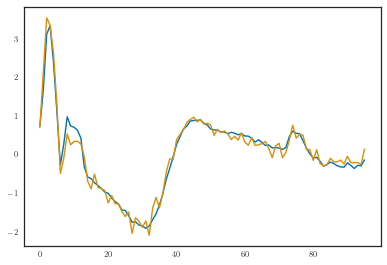

In [131]:
plt.plot(b.cluster_centers_[8,:])
plt.plot(x_train[0,:])

array([1])

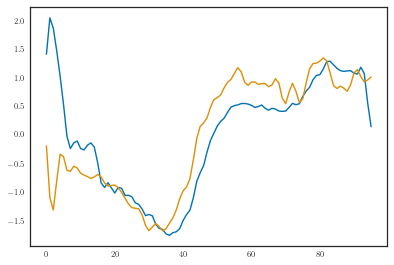

In [161]:
trf = t.transform(x_train[6, :].reshape(1, -1)).reshape(-1)
plt.plot(trf)
plt.plot(x_train[6, :])
t.predict(trf.reshape(1, -1))

In [163]:
cond = t.predict(x_test) == from_label
x_from = x_test[cond]
y_from = y_test[cond]
x_prime = t.transform(x_from)

In [164]:
x_from_ir = x_from
x_prime_ir = x_prime

In [165]:
t.score(x_test, y_test)

0.9666666666666667

In [166]:
neigh = NearestNeighbors(1, metric="euclidean")
neigh.fit(x_train[y_train == to_label])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=1, p=2, radius=1.0)

[2]
[[48]]
Transformation cost    : 5.5306363902273485
Transformation fraction: 1.0


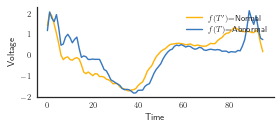

In [167]:
idx=np.random.randint(0, x_prime.shape[0], size=1)#
print(idx)
def plot_example(ax, x_i, min_x, closest, x_train, y_train, to_label, from_label, nn_x=None):
    ax.plot(min_x, color=sns.xkcd_rgb["amber"], label="$f(T')$={}".format("Normal"))
    ax.plot(x_i, color=sns.xkcd_rgb["windows blue"], label="$f(T)$={}".format("Abnormal"))
    if nn_x is not None:
        ax.plot(nn_x, 
                c="gray", 
                dashes=[2, 2], 
                label="$NN_1(T,  D_{y=" + str("Normal") + "})$",
        )

closest = neigh.kneighbors(x_from[idx], return_distance=False)
print(closest)
nn_x = x_train[y_train == to_label][closest.reshape(-1)].reshape(-1)
fig, ax = plt.subplots(1)
plot_example(ax, 
             x_from[idx].reshape(-1), 
             x_prime[idx].reshape(-1), 
             closest, 
             x_train, 
             y_train, 
             to_label, 
             from_label, 
             None)
#plot_example(ax, x_from[idx], nn_x_prime[idx], closest, x_train, y_train, to_label, from_label)
plt.legend(loc=1)
plt.xlabel("Time")
plt.ylabel("Voltage")
#plt.ylim([-3, 6])
set_size(fig, ax)
#plt.title("SE transform (cost: {:.2f}, %-change: {:.2f})")
plt.savefig("figure/ecg_200_motivation.pdf")
print("Transformation cost    :", cost(x_prime[idx].reshape(1, -1), x_from[idx].reshape(1, -1)))
print("Transformation fraction:", differences(x_prime[idx], x_from[idx], axis=0))

Transformation cost    : 1.0190504504710192
Transformation fraction: 0.15625


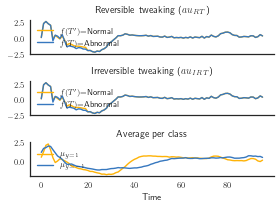

In [150]:
idx=1 # change me
closest = neigh.kneighbors(x_from[idx].reshape(1, -1), return_distance=False)
fig, [ax_1, ax_2, ax_3] = plt.subplots(3, sharex=True)
plot_example(ax_2, x_from[idx], x_prime[idx], closest, x_train, y_train, to_label, from_label)
plot_example(ax_1, x_from_ir[idx], x_prime_ir[idx], closest, x_train, y_train, to_label, from_label)
#plot_example(ax, x_from[idx], nn_x_prime[idx], closest, x_train, y_train, to_label, from_label)
ax_1.legend()
ax_2.legend()
#ax_1.set_xlabel("Time")
#ax_1.set_ylabel("Spectral density")
ax_1.set_title("Reversible tweaking ($\tau_{RT}$)")
ax_2.set_title("Irreversible tweaking ($\tau_{IRT}$)")
ax_3.plot(np.mean(x_test[y_test==to_label], axis=0), color=sns.xkcd_rgb["amber"], label="$\\mu_{y="+str(to_label)+"}$")
ax_3.plot(np.mean(x_test[y_test==from_label], axis=0),  color=sns.xkcd_rgb["windows blue"], label="$\\mu_{y="+str(from_label)+"}$")
#ax_3.plot(np.mean(x_prime_ir, axis=0),  color=sns.xkcd_rgb["blue"], label="$\\mu_{y="+str(from_label)+"}$")
#ax_3.plot(np.nanmean(x_prime, axis=0),  color=sns.xkcd_rgb["green"], label="$\\mu_{y="+str(from_label)+"}$")
ax_3.set_title("Average per class")
ax_3.set_xlabel("Time")
ax_3.legend()
#ax_2.set_ylabel("Spectral density")
set_size(fig, [ax_1, ax_2, ax_3], height=3)
#plt.title("SE transform (cost: {:.2f}, %-change: {:.2f})")
plt.savefig("figure/example_transform_insect.pdf")
print("Transformation cost    :", cost(x_prime[idx].reshape(1, -1), x_from[idx].reshape(1, -1)))
print("Transformation fraction:", differences(x_prime[idx], x_from[idx], axis=0))

In [21]:
def plot_example(ax, x_i, min_x, closest, x_train, y_train, to_label, from_label):
    ax.plot(min_x, color=sns.xkcd_rgb["amber"], label="$f(T')={}$".format(to_label))
    ax.plot(x_i, color=sns.xkcd_rgb["windows blue"], label="$f(T)={}$".format(from_label))
    for i in range(closest.shape[1]):
        ax.plot(x_train[y_train == to_label][closest[0, i]], 
                c="gray", 
                dashes=[2, 2], 
                label="$NN_1(T',  D_{y=" + str(to_label) + "})$",
        )

closest = neigh.kneighbors(x_prime[idx].reshape(1, -1), return_distance=False)
fig, ax = plt.subplots(1)
plot_example(ax, x_from[idx], x_prime[idx], closest, x_train, y_train, to_label, from_label)
plt.legend()
set_size(fig, ax)
#plt.title("SE transform (cost: {:.2f}, %-change: {:.2f})")
plt.savefig("figure/gun_point_example.pdf")
print("Transformation cost    :", cost(x_prime[idx].reshape(1, -1), x_from[idx].reshape(1, -1)))
print("Transformation fraction:", differences(x_prime[idx], x_from[idx]))

ValueError: query data dimension must match training data dimension

In [3]:
def shape_transform_(s, x, i, theta):
    """
    :param s: the shapelet
    :param x: the time series
    :param i: the matching location
    :param theta: the desired distance
    :returns: the shapelet with `theta`-distance
    """
    x_match = x[i:(i + s.shape[0])]
    v = (x_match - s) 
    norm_v = np.linalg.norm(v)
    if norm_v == 0:
        x_match = np.random.uniform(s.shape)
        v = (x_match - s)
        norm_v = np.linalg.norm(v)

    return s + v / norm_v * theta

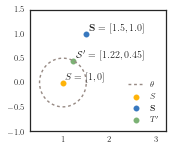

In [14]:
def circ(r):
    x = np.linspace(0, 2*np.pi, 100)
    return r*np.cos(x), r*np.sin(x)

fig, ax = plt.subplots(1)
#if s.shape[0] == 2:
plt.plot(*(np.vstack(circ(theta))+s.reshape(-1, 1)), color=sns.xkcd_rgb["warm grey"], dashes=[2,2], label="$\\theta$")
#elif s.shape[0] == 1:
#plt.plot(np.arange(-theta, theta), np.zeros(theta*2))
#else:
#    raise ValueError()
plt.scatter(*s, label="$S$", color=sns.xkcd_rgb["amber"])
plt.annotate("$S=[{}]$".format(",".join(map(str, s))), xy=s+0.05)
plt.scatter(*t, label="$\\mathbf{S}$", color=sns.xkcd_rgb["windows blue"])
plt.annotate("$\\mathbf{{S}}=[{}]$".format(",".join(map(str, t))), xy=t+0.05)
plt.scatter(*p, label="$T'$", color=sns.xkcd_rgb["faded green"])
plt.annotate("$\\mathcal{{S}}'=[{}]$".format(",".join(map(lambda ss: "{:.2f}".format(ss), p))), xy=p+0.05)
plt.legend(loc=4)
plt.ylim([-1, 1.5])
plt.xlim([0.3, 3.2])
set_size(fig, ax, width=2.5, height=2.2)
sns.despine(fig, ax, top=False, right=False)
plt.savefig("figure/example_move.pdf")
#plt.xlim([-theta*2, theta*2])
#plt.ylim([-theta*2, theta*2])